# Anitápolis AMF multiple Inversions

This notebook performs the inversion using Levenberg-Marquadt's amplitude of magnetic anomalous field (AMF).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle
import os
import pandas as pd

from fatiando.vis import mpl

/home/leonardo/anaconda2/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


In [2]:
from datetime import date
today = date.today()
# dd/mm/YY
d4 = today.strftime("%b-%d-%Y")

### Auxiliary functions

In [3]:
import sys
sys.path.insert(0, '../../code')

import mag_polyprism_functions as mfun

# Input

### Importing model parameters

In [4]:
data = pd.read_csv('anitapolis_decimated_amf_cut.txt', skipinitialspace=True, delim_whitespace=True)

In [5]:
data['z'] = data['z'] + 800

In [6]:
mask = (data['y'] <= 693000) & (data['y'] >= 683000.) & (data['x'] <= 6926000.) & (data['x'] >= 6916000.) & (data['z'].get_values()<0.)
data = data[mask]

In [7]:
xp = data['x'].get_values()
yp = data['y'].get_values()
zp = data['z'].get_values()
dobs = data['amf'].get_values()

In [8]:
zp

array([-293.1 , -282.71, -271.11, ..., -335.43, -335.79, -337.13])

In [9]:
# output of inversion
inversion = dict()

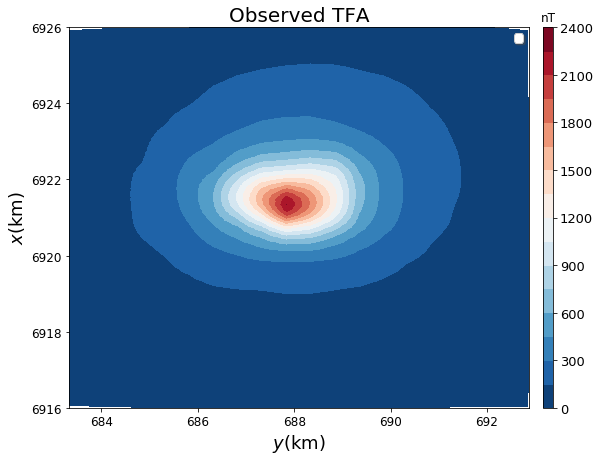

In [10]:
plt.figure(figsize=(10,7))
plt.title('Observed TFA', fontsize=20)
plt.tricontourf(yp, xp, dobs, 20, cmap='RdBu_r').ax.tick_params(labelsize=12)
plt.xlabel('$y$(km)', fontsize=18)
plt.ylabel('$x$(km)', fontsize=18)
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
#estimate = mpl.polygon(model0[0], '.-r', xy2ne=True)
#estimate.set_label('Initial estimate')
clb.ax.set_title('nT')
mpl.m2km()
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1)
plt.show()

### Parameters of the initial model

In [11]:
M = 20 # number of vertices per prism
L = 6 # number of prisms
P = L*(M+2) + 1 # number of parameters

#figura
incs = -21
decs = -11
int_min = 11
int_max = 20
intensity = np.linspace(int_min, int_max, 10)

# depth to the top, thickness and radius
z0_min = 0.
z0_max = 180.
z0 = np.linspace(z0_min, z0_max, 10)
dz = 900.
r = 700.

# origin
x0 = 6921000.
y0 = 688000.

# main field
inc, dec = [-37.05, -18.17]

In [12]:
z0

array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160., 180.])

In [13]:
intensity

array([11., 12., 13., 14., 15., 16., 17., 18., 19., 20.])

### Limits

In [14]:
# limits for parameters in meters
rmin = 10.
rmax = 1200.
y0min = 687000.
y0max = 699000.
x0min = 6916000.
x0max = 6923000.
dzmin = 10.
dzmax = 1000.

mmin, mmax = mfun.build_range_param(M, L, rmin, rmax, x0min, x0max, y0min, y0max, dzmin, dzmax)

### Variation

In [15]:
# variation for derivatives
deltax = 0.01*np.max(100.)
deltay = 0.01*np.max(100.)
deltar = 0.01*np.max(100.)
deltaz = 0.01*np.max(100.)

### Outcropping parameters

In [16]:
# outcropping body parameters
m_out = np.zeros(M + 2)
#m_out = model['param_vec'][:M+2]

### Folder to save the results

In [17]:
mypath = 'amf_inversion/multiple_int_min%d_int_max%d_z0_min%d_z0_max%d_r%d_dz%d_V%d_L%d' % (int_min, int_max, z0_min, z0_max, r, dz, M, L)
mypath += d4
if not os.path.isdir(mypath):
   os.makedirs(mypath)

In [18]:
mypath

'amf_inversion/multiple_int_min11_int_max20_z0_min0_z0_max180_r700_dz900_V20_L6May-01-2020'

### Regularization parameters

In [19]:
#lamb = th*0.01 # Marquadt's parameter
lamb = 10.0
dlamb = 10.      # step for Marquadt's parameter

a1 = 1.0e-3  # adjacent radial distances within each prism
a2 = 1.0e-4   # vertically adjacent radial distances
a3 = 0.     # outcropping cross-section
a4 = 0.     # outcropping origin
a5 = 1.0e-3     # vertically adjacent origins
a6 = 1.0e-8   # zero order Tikhonov on adjacent radial distances
a7 = 1.0e-5     # zero order Tikhonov on thickness of each prism

In [20]:
delta = np.array([deltax, deltay, deltar, deltaz])
alpha = np.array([a1, a2, a3, a4, a5, a6, a7])

In [21]:
itmax = 30
itmax_marq = 10
tol = 1.0e-4     # stop criterion

In [22]:
inversion['x'] = xp
inversion['y'] = yp
inversion['z'] = zp
inversion['observed_data'] = dobs

In [23]:
inversion['x'].size

1597

In [24]:
inversion['inc_dec'] = [incs, decs]
inversion['z0'] = z0
inversion['initial_dz'] = dz
inversion['intial_r'] = r
inversion['limits'] = [rmin, rmax, x0min, x0max, y0min, y0max, dzmin, dzmax]
inversion['regularization'] = alpha
inversion['tol'] = tol
inversion['main_field'] = [inc, dec]
inversion['intensity'] = intensity
#inversion['topography'] = -(di['zt'] - 100.)

### Inversion

In [25]:
inversion_results = []
for j, z in enumerate(z0):
    for k, i in enumerate(intensity):
        alpha = np.array([a1, a2, a3, a4, a5, a6, a7])
        print 'inversion: %d  top: %d  intensity: %.1e' % (j*z0.size + k, z, i)
        model0, m0 = mfun.initial_cylinder(M, L, x0, y0, z, dz, r, inc, dec, incs, decs, i)
        d_fit, m_est, model_est, phi_list, model_list, res_list = mfun.levmarq_amf(
            xp, yp, zp, m0, M, L, delta,
            itmax, itmax_marq, lamb,
            dlamb, tol, mmin, mmax,
            m_out, dobs,
            model0[0].props, alpha, z, dz
        )
        inversion_results.append([m_est, phi_list, model_list, dobs - d_fit])

inversion: 0  top: 0  intensity: 1.1e+01
it:  0   it_marq:  0   lambda: 1e+01   init obj.: 8.79964e+03  fin obj.: 6.87106e+03
it:  1   it_marq:  0   lambda: 1e+00   init obj.: 6.87106e+03  fin obj.: 3.73324e+03
it:  2   it_marq:  0   lambda: 1e-01   init obj.: 3.73324e+03  fin obj.: 3.25638e+03
it:  3   it_marq:  0   lambda: 1e-02   init obj.: 3.25638e+03  fin obj.: 1.04377e+05
it:  3   it_marq:  1   lambda: 1e-01   init obj.: 3.25638e+03  fin obj.: 1.09602e+04
it:  3   it_marq:  2   lambda: 1e+00   init obj.: 3.25638e+03  fin obj.: 3.11516e+03
it:  4   it_marq:  0   lambda: 1e-01   init obj.: 3.11516e+03  fin obj.: 6.20121e+04
it:  4   it_marq:  1   lambda: 1e+00   init obj.: 3.11516e+03  fin obj.: 3.40838e+03
it:  4   it_marq:  2   lambda: 1e+01   init obj.: 3.11516e+03  fin obj.: 5.47694e+03
it:  4   it_marq:  3   lambda: 1e+02   init obj.: 3.11516e+03  fin obj.: 4.50859e+03
it:  4   it_marq:  4   lambda: 1e+03   init obj.: 3.11516e+03  fin obj.: 3.09435e+03
it:  5   it_marq:  0   l

# Results

In [28]:
inversion['results'] = inversion_results

In [29]:
file_name = mypath+'/inversion.pickle'
with open(file_name, 'w') as f:
    pickle.dump(inversion, f)